Imports and Setup

In [2]:
import sqlite3
import ast
import json
import time
import os
import fnmatch
import plotly.express as px
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import requests
import plotly.graph_objs as go

from pyvis.network import Network
from pandas.io.json import json_normalize
from os import listdir
from os.path import isfile, join

base_path = '../../../go/dev/alice/'

try:
    #connection = sqlite3.connect(base_path+'sqlite/db')
    connection = sqlite3.connect(base_path+'sqlite/final')
except sqlite3.Error as e:
    print(e)
    exit()

cursor = connection.cursor()

def create_json_for_joined_table_entry(joined_data):
    result = {}

    result['on_chain'] = ast.literal_eval(joined_data[1])
    result['off_chain'] = ast.literal_eval(joined_data[6])

    return result

def get_snaphot_amount():
    graph_file_names = [f for f in listdir(base_path + 'graph_backup/') if isfile(join(base_path + 'graph_backup/', f))]
    graph_file_names.remove('.info')
    return len(graph_file_names)

def get_ip_from_node(node):
    if not node['addresses'] or len(node['addresses']) == 0:
        return None
    
    for address in node['addresses']:
        if address['network'] == 'tcp' and address['addr'].count('.') == 3 and address['addr'].count(':') == 1 and len(address['addr']) < 22:
            return address['addr'].split(':')[0]
        elif address['network'] == 'tcp' and 'onion' in address['addr']:
            return 'Tor'
        else:
            return 'Other'
    
    return None

Channel Statistics

In [5]:
cursor.execute('select raw_data from potential_txes')

raw_channel_data = [ast.literal_eval(element[0]) for element in cursor.fetchall()]

potential_onchain_ln_tx_from_snapshot_begin = []

for data in raw_channel_data:
    if int(data['block_height_closing_tx']) >= 605798:
        potential_onchain_ln_tx_from_snapshot_begin.append(data)

print(str(len(raw_channel_data)) + ' potential onchain LN transactions (500,000 - 613024 - roughly from the begin of 2018)')
print(str(len(potential_onchain_ln_tx_from_snapshot_begin)) + ' potential onchain LN transactions, where closing block height is greater than 605798 (begin of hourly LN snapshots)')

195158 potential onchain LN transactions (500,000 - 613024 - roughly from the begin of 2018)
18849 potential onchain LN transactions, where closing block height is greater than 605798 (begin of hourly LN snapshots)


In [6]:
uncooperative_closed_channels = []

for filename in os.listdir(base_path+'blockchain_export/'):
    if fnmatch.fnmatch(filename, 'potential_uncooperative_channel_txes_*'):
        uncooperative_closed_channels += json.load(open(base_path+'blockchain_export/'+filename))

uncooperative_closed_channels_from_snapshot_begin = []

for data in uncooperative_closed_channels:
    if int(data['block_height_closing_tx']) >= 605798:
        uncooperative_closed_channels_from_snapshot_begin.append(data)

print(str(len(uncooperative_closed_channels)) + ' potential uncooperative onchain LN transactions (500,000 - 613024 - roughly from the begin of 2018)')
print(str(len(uncooperative_closed_channels_from_snapshot_begin)) + ' potential uncooperative onchain LN transactions, where closing block height is greater than 605798 (begin of hourly LN snapshots)')

42205 potential uncooperative onchain LN transactions (500,000 - 613024 - roughly from the begin of 2018)
4604 potential uncooperative onchain LN transactions, where closing block height is greater than 605798 (begin of hourly LN snapshots)


In [7]:
potential_channel_closing_types = [{"type": "cooperative", "count": len(raw_channel_data)-len(uncooperative_closed_channels)}, {"type": "non-cooperative", "count": len(uncooperative_closed_channels)}]
potential_channel_closing_types_from_snapshot_begin = [{"type": "cooperative", "count": len(potential_onchain_ln_tx_from_snapshot_begin)-len(uncooperative_closed_channels_from_snapshot_begin)}, {"type": "non-cooperative", "count": len(uncooperative_closed_channels_from_snapshot_begin)}]

fig = px.pie(potential_channel_closing_types, values='count', names='type', title="Channel closing types (from block #500000)")
fig.show()

fig = px.pie(potential_channel_closing_types_from_snapshot_begin, values='count', names='type', title="Channel closing types (from block #605798)")
fig.show()

In [8]:
cursor.execute('select count(*) from channels')
number_total_unique_channels = cursor.fetchall()[0][0]

print(str(number_total_unique_channels) + ' total unique channels were found off-chain')

42755 total unique channels were found off-chain


In [9]:
current_timestamp = int(time.time())
remainer = current_timestamp % 3600

latest_snapshot_hour = current_timestamp-remainer

cursor.execute('select count(*) from channel_snapshots where timestamp = ? or timestamp = ? ', (latest_snapshot_hour+1,latest_snapshot_hour+2))
number_known_channels_latest_snapshot = cursor.fetchall()[0][0]

print(str(number_known_channels_latest_snapshot) + ' channels were known to the node on last snapshot')

36358 channels were known to the node on last snapshot


In [10]:
cursor.execute('select * from potential_txes p inner join channels c on p.tx = c.funding_tx')
closed_channels_onchain = [create_json_for_joined_table_entry(element) for element in cursor.fetchall()]

print('more restrictive: ' + str(len(closed_channels_onchain)) + ' channels of unique channels where found, where also onchain channel closing transactions exists')

more restrictive: 5689 channels of unique channels where found, where also onchain channel closing transactions exists


In [3]:
cursor.execute('select raw_data from potential_txes')
total_pot_txes = [ast.literal_eval(element) for element[0] in cursor.fetchall()]

pot_txes = [element for element in total_pot_txes if element['block_height_closing_tx'] >= 605798]

cursor.execute('select raw_data from channels')
total_pot_txes = [ast.literal_eval(element) for element[0] in cursor.fetchall()]

print('more restrictive: ' + str(len(total_pot_txes_with_no_channel)) + ' potential txes, that do not match any recorded channel (from block height 500,000)')

KeyboardInterrupt: 

In [50]:


print('more restrictive: ' + str(len(pot_txes_with_no_channel)) + ' potential txes, that do not match any recorded channel (from block height 605,798)')

more restrictive: 0 potential txes, that do not match any recorded channel (from block height 605,798)


In [11]:
cursor.execute('select * from potential_txes_less_restrictive p inner join channels c on p.tx = c.funding_tx')
closed_channels_onchain = [create_json_for_joined_table_entry(element) for element in cursor.fetchall()]

print('less restrictive: ' + str(len(closed_channels_onchain)) + ' channels of unique channels where found, where also onchain channel closing transactions exists')

less restrictive: 5691 channels of unique channels where found, where also onchain channel closing transactions exists


In [12]:
closed_channels_onchain_offchain = [{"type": "on-chain (not verified)", "count": len(potential_onchain_ln_tx_from_snapshot_begin)-len(closed_channels_onchain)}, {"type": "off-chain (verified)", "count": len(closed_channels_onchain)}]

fig = px.pie(closed_channels_onchain_offchain, values='count', names='type', title="Closed channels (potential transactions from blockchain vs channels)")
fig.show()

In [13]:
channel_openings_at_block = {}
channel_closings_at_block = {}
channel_durations = {}
channel_balances = {}

for channel in closed_channels_onchain:
    try:
        channel_openings_at_block[channel['on_chain']['block_height_funding_tx']] += 1
    except KeyError as e:
        channel_openings_at_block[channel['on_chain']['block_height_funding_tx']] = 1
    
    try:
        channel_closings_at_block[channel['on_chain']['block_height_closing_tx']] += 1
    except KeyError as e:
        channel_closings_at_block[channel['on_chain']['block_height_closing_tx']] = 1
    
    try:
        channel_durations[channel['on_chain']['block_height_closing_tx']-channel['on_chain']['block_height_funding_tx']] += 1
    except KeyError as e:
        channel_durations[channel['on_chain']['block_height_closing_tx']-channel['on_chain']['block_height_funding_tx']] = 1
    
    try:
        channel_balances[channel['off_chain']['capacity']] += 1
    except KeyError as e:
        channel_balances[channel['off_chain']['capacity']] = 1

channel_openings_at_block = {k: channel_openings_at_block[k] for k in sorted(channel_openings_at_block)}
channel_closings_at_block = {k: channel_closings_at_block[k] for k in sorted(channel_closings_at_block)}
channel_durations = {k: channel_durations[k] for k in sorted(channel_durations)}
channel_balances = {k: channel_balances[k] for k in sorted(channel_balances)}

df_channel_openings_at_block = pd.DataFrame({'block_heights': list(channel_openings_at_block.keys()), 'counts': list(channel_openings_at_block.values())})
df_channel_closings_at_block = pd.DataFrame({'block_heights': list(channel_closings_at_block.keys()), 'counts': list(channel_closings_at_block.values())})
df_channel_durations = pd.DataFrame({'block_durations': list(channel_durations.keys()), 'counts': list(channel_durations.values())})
df_channel_balances = pd.DataFrame({'channel_balances': list(channel_balances.keys()), 'counts': list(channel_balances.values())})

fig = px.histogram(df_channel_openings_at_block, x='block_heights', title='Channels opened at block', nbins=250)
fig.show()

fig = px.histogram(df_channel_closings_at_block, x='block_heights', title='Channels closed at block', nbins=250)
fig.show()

fig = px.histogram(df_channel_durations, x='block_durations', title='Channel durations in blocks', nbins=250)
fig.show()

fig = px.histogram(df_channel_balances, x='channel_balances', title='Channel balances (closed channels)', nbins=100)
fig.show()

block_durations = list(channel_durations.keys())
block_durations.sort()

block_duration_average = sum(block_durations)/len(block_durations)
block_duration_median = (block_durations[(len(block_durations)//2)]+block_durations[~(len(block_durations)//2)])/2

print('channel duration average is: '+str(block_duration_average)+' blocks ('+ str(block_duration_average*10/60/24) +' days)')
print('channel duration median is: '+str(block_duration_median)+' blocks ('+ str(block_duration_median*10/60/24) +' days)')

channel duration average is: 25034.128381106177 blocks (173.84811375768177 days)
channel duration median is: 19466.0 blocks (135.18055555555557 days)


In [10]:
cursor.execute('select distinct timestamp from channel_snapshots')
timestamps = [element[0] for element in cursor.fetchall()]

snapshot_channel_count = {}

while len(timestamps) > 0:
    try:
        cursor.execute('select count(*) from channel_snapshots where timestamp = ?', (timestamps[0],))
        snapshot_channel_count[str(timestamps[0])] = cursor.fetchall()[0][0]
        timestamps.remove(timestamps[0])
        
    except sqlite3.OperationalError as e:
        pass

snapshot_channel_count = {k: snapshot_channel_count[k] for k in sorted(snapshot_channel_count)}

df_snapshot_channel_count = pd.DataFrame({'timestamps': list(snapshot_channel_count.keys()), 'counts': list(snapshot_channel_count.values())})

KeyboardInterrupt: 

In [15]:
df_snapshot_channel_count.nlargest(1, 'counts')

,timestamps,counts
1404,1580043601,36435


In [16]:
df_snapshot_channel_count.nsmallest(1, 'counts')

,timestamps,counts
0,1574971201,26369


In [6]:
fig = px.histogram(df_snapshot_channel_count, y="counts", title='Channels per timestamp')
fig.show()

NameError: name 'df_snapshot_channel_count' is not defined

In [18]:
cursor.execute('select channel,idx,count(timestamp) from channel_snapshots group by channel having count(timestamp) < ?', (get_snaphot_amount(),))

result = cursor.fetchall()

channels_with_lack_of_snapshots = []

for res in result:
    cursor.execute('select timestamp from channel_snapshots where channel = ? and idx = ?', (res[0], res[1]))

    timestamps = [element[0] for element in cursor.fetchall()]

    timestamps.sort()

    lack_of_snapshots = []

    for i in range(1, len(timestamps)):
        #3600 seconds +/-1 second because there are snapshots taken at second 2 of a hour, insted of second 1 of a hour
        if (timestamps[i-1]+3600 != timestamps[i]) and (timestamps[i-1]+3599 != timestamps[i]) and (timestamps[i-1]+3601 != timestamps[i]):
            lack_of_snapshots.append(timestamps[i]-timestamps[i-1])

    if len(lack_of_snapshots) > 0:
        channels_with_lack_of_snapshots.append({'funding_tx': res[0], 'output_idx': res[1], 'lack_of_snapshots': lack_of_snapshots})


print(str(len(channels_with_lack_of_snapshots)) + ' channels are not part of every snapshot during their range of snapshots')

37046 channels are not part of every snapshot during their range of snapshots


In [19]:
channels_with_onchain_data = json.load(open(base_path+'channels/all_channel_export_1579092768_onchain_data'))

openChannels = []
closedChannels = []

for channel_with_onchain_data in channels_with_onchain_data:
    if channel_with_onchain_data['active']:
        openChannels.append(channel_with_onchain_data)
    else:
        closedChannels.append(channel_with_onchain_data)

print(str(len(openChannels))+' open channels (checked unique channels against onchain transactions - output not spent)')
print(str(len(closedChannels))+' closed channels (checked unique channels against onchain transactions - output spent)')

36306 open channels (checked unique channels against onchain transactions - output not spent)
4721 closed channels (checked unique channels against onchain transactions - output spent)


In [20]:
channels_with_onchain_data = json.load(open(base_path+'channels/closed_channel_export_1579333342_onchain_data'))

openChannels = []
closedChannels = []

for channel_with_onchain_data in channels_with_onchain_data:
    if channel_with_onchain_data['active']:
        openChannels.append(channel_with_onchain_data)
    else:
        closedChannels.append(channel_with_onchain_data)

print(str(len(channels_with_onchain_data))+' total closed believed (unique channels not present in last snapshot) channels')
print(str(len(closedChannels))+' closed channels (closed believed: unique channels not present in last snapshot) (checked ln channels against on chain transactions)')
print(str(len(openChannels))+' open channels (closed believed: unique channels not present in last snapshot) (checked ln channels against on chain transactions)')

5252 total closed believed (unique channels not present in last snapshot) channels
5011 closed channels (closed believed: unique channels not present in last snapshot) (checked ln channels against on chain transactions)
241 open channels (closed believed: unique channels not present in last snapshot) (checked ln channels against on chain transactions)


In [9]:
closed_believed_channels = [{"type": "actually closed", "count": len(closedChannels)}, {"type": "actually not closed", "count": len(openChannels)}]

fig = px.pie(closed_believed_channels, values='count', names='type', title="Channels from LN snapshots believed to be closed (checked onchain transactions)")
fig.show()

Graph Statistics

In [14]:
cursor.execute('select raw_data from channels')
unique_channels = [ast.literal_eval(element[0]) for element in cursor.fetchall()]

binned_channel_balances = [{'bin': '0-10,000 satoshi', 'count': 0}, {'bin': '10,001-100,000 satoshi', 'count': 0}, {'bin': '100,001-1,000,000 satoshi', 'count': 0}, {'bin': '1,000,001-10,000,000 satoshi', 'count': 0}, {'bin': '10,000,001-100,000,000', 'count': 0}, {'bin': 'more than 100,000,000 satoshi', 'count': 0}]

node_channel_count = {}
capacities = []

for unique_channel in unique_channels:
    try:
        node_channel_count[unique_channel['node1_pub']] += 1
    except KeyError as e:
        node_channel_count[unique_channel['node1_pub']] = 1
    
    try:
        node_channel_count[unique_channel['node2_pub']] += 1
    except KeyError as e:
        node_channel_count[unique_channel['node2_pub']] = 1
    
    if int(unique_channel['capacity']) < 10001:
        binned_channel_balances[0]['count'] += 1
    elif int(unique_channel['capacity']) < 100001:
        binned_channel_balances[1]['count'] += 1
    elif int(unique_channel['capacity']) < 1000001:
        binned_channel_balances[2]['count'] += 1
    elif int(unique_channel['capacity']) < 10000001:
        binned_channel_balances[3]['count'] += 1
    elif int(unique_channel['capacity']) < 100000001:
        binned_channel_balances[4]['count'] += 1
    else:
        binned_channel_balances[5]['count'] += 1
    
    capacities.append(int(unique_channel['capacity']))

node_channel_count = {k: node_channel_count[k] for k in sorted(node_channel_count)}

df_node_channel_count = pd.DataFrame({'nodes': list(node_channel_count.keys()), 'counts': list(node_channel_count.values())})

fig = px.histogram(df_node_channel_count, x='counts', title='Channels per node')
fig.show()

fig = px.pie(binned_channel_balances, values='count', names='bin', title="Channels per balance")
fig.show()

capacities.sort()
capacities_average = sum(capacities)/len(capacities)
capacities_median = (capacities[(len(capacities)//2)]+capacities[~(len(capacities)//2)])/2

print('capacities average is: '+str(capacities_average)+' satoshi ('+str(capacities_average/100000000)+' BTC)')
print('capacities median is: '+str(capacities_median)+' satoshi ('+str(capacities_median/100000000)+' BTC)')

capacities average is: 2453812.369544426 satoshi (0.02453812369544426 BTC)
capacities median is: 500000.0 satoshi (0.005 BTC)


In [23]:
binned_node_channel_count = [{'bin': '1 channel', 'count': 0}, {'bin': '2-10 channels', 'count': 0}, {'bin': '11-100 channels', 'count': 0}, {'bin': '101-1000 channels', 'count': 0}, {'bin': '1001-10000 channels', 'count': 0}, {'bin': 'more than 10000 channels', 'count': 0}]

for key in node_channel_count.keys():
    if node_channel_count[key] == 1:
        binned_node_channel_count[0]['count'] += 1
    elif node_channel_count[key] < 11:
        binned_node_channel_count[1]['count'] += 1
    elif node_channel_count[key] < 101:
        binned_node_channel_count[2]['count'] += 1
    elif node_channel_count[key] < 1001:
        binned_node_channel_count[3]['count'] += 1
    elif node_channel_count[key] < 10001:
        binned_node_channel_count[4]['count'] += 1
    else:
        binned_node_channel_count[5]['count'] += 1

fig = px.pie(binned_node_channel_count, values='count', names='bin', title="Channels per node")
fig.show()

print(str(len(node_channel_count)) + ' nodes in LN')

6845 nodes in LN


In [16]:
print('Top 5 nodes with the most channels')

n_largest = df_node_channel_count.nlargest(250, 'counts')

Top 5 nodes with the most channels


In [17]:
node_locations = {}

for node_pub in n_largest['nodes'].array:
    cursor.execute('select raw_data from nodes where pub_key = ?', (node_pub,))
    node = ast.literal_eval(cursor.fetchall()[0][0])
    
    ip_address = get_ip_from_node(node)
    
    if not ip_address:
        print('no ip for node: ' + node_pub)
        continue
    
    response = requests.get(url = 'http://api.ipstack.com/[IP]?access_key=78042c1aa6f3db927fb3d91bea1a9760'.replace('[IP]', ip_address))
    response_data = response.json()
    
    node_locations[node_pub] = response_data

print('loaded geo locations for ' + str(len(node_locations)) + ' / ' + str(len(n_largest)) + ' nodes')

no ip for node: 038247a593349447d67eb2444132bb8b54ecdc146e910d1ce5959b91b0da5ff758
no ip for node: 02d246c519845e7b23b02684d64ca23b750958e0307f9519849ee2535e3637999a
no ip for node: 03e28800c579c3d0c3a728742c016cb329e5a5ff256dd32635998243df2a82c3a0
no ip for node: 034a5fdb2df3ce1bfd2c2aca205ce9cfeef1a5f4af21b0b5e81c453080c30d7683
no ip for node: 0394396e6e8cf8d9f91de4269dfd2e8416b93b91cae6139057c7283b463e4bfa31
no ip for node: 020fccc5602053c438b13ebee7aa31a25e9c3803baace5afcecedff8db70543747
no ip for node: 02870c077874b6c294f6351511fd2eb239754ebfe91f6c9eccc980c94cecd5fa07
no ip for node: 03ce15213fc42f04132edc0acb73d5830371970bebd7e25ba4a3ca2552d1ae6fdf
no ip for node: 020d3d5995a973c878e3f6e5f59da54078304c537f981d7dcef73367ecbea0e90e
no ip for node: 0308525b40384ef5b8729fcae1615c4e206c1b38e97f72e226a839167fb4336438
no ip for node: 03cbf298b068300be33f06c947b9d3f00a0f0e8089da3233f5db37e81d3a596fe1
no ip for node: 02df5ffe895c778e10f7742a6c5b8a0cefbe9465df58b92fadeb883752c8107c8f
no i

In [19]:
df_node_locations = pd.DataFrame({"nodes": list(node_locations.keys()), "latitudes": [element['latitude'] for element in node_locations.values()], "longitudes": [element['longitude'] for element in node_locations.values()], "cities": [element['city'] for element in node_locations.values()]})

map = [go.Scattergeo(
          lon = df_node_locations['longitudes'],
          lat = df_node_locations['latitudes'],
          hoverinfo = 'text',
          text = df_node_locations['cities'],
          mode = 'markers',
          marker_color = 'blue'
          )]

fig = go.Figure(data = map)
fig.update_layout(
    title="Locations of 250 nodes with most channels",
)
fig.show()

In [27]:
channel_graph = nx.Graph()

cursor.execute('select raw_data from channels')
unique_channels = [ast.literal_eval(element[0]) for element in cursor.fetchall()]

for channel in unique_channels:
    channel_graph.add_edge(channel['node1_pub'], channel['node2_pub'])

In [28]:
print(str(channel_graph.number_of_edges()) + ' channels in graph (less than unique channels because some nodes and channels have / had more than 1 channel)')
print(str(channel_graph.number_of_nodes()) + ' nodes in graph')

degree_centrality = nx.degree_centrality(channel_graph)

df_degree_centrality = pd.DataFrame({'nodes': list(degree_centrality.keys()), 'centralities': list(degree_centrality.values())})

print('Top 5 nodes with the highest degree centralities')
df_degree_centrality.nlargest(5, 'centralities')

38042 channels in graph (less than unique channels because some nodes and channels have / had more than 1 channel)
6845 nodes in graph
Top 5 nodes with the highest degree centralities


,nodes,centralities
554,02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f...,0.214056
2127,0331f80652fb840239df8dc99205792bba2e559a054699...,0.156049
1266,0217890e3aad8d35bc054f43acc00084b25229ecff0ab6...,0.137054
823,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,0.131794
1544,0279c22ed7a068d10dc1a38ae66d2d6461e269226c6025...,0.116598


In [29]:
closeness_centrality = nx.closeness_centrality(channel_graph)

df_closeness_centrality = pd.DataFrame({'nodes': list(closeness_centrality.keys()), 'centralities': list(closeness_centrality.values())})

print('Top 5 nodes with the highest closeness centralities')
df_closeness_centrality.nlargest(5, 'centralities')

Top 5 nodes with the highest closeness centralities


,nodes,centralities
554,02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f...,0.495362
1544,0279c22ed7a068d10dc1a38ae66d2d6461e269226c6025...,0.460122
823,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,0.457546
2127,0331f80652fb840239df8dc99205792bba2e559a054699...,0.451868
1231,0242a4ae0c5bef18048fbecf995094b74bfb0f7391418d...,0.441624


In [30]:
betweenness_centrality = nx.betweenness_centrality(channel_graph)

df_betweenness_centrality = pd.DataFrame({'nodes': list(betweenness_centrality.keys()), 'centralities': list(betweenness_centrality.values())})

print('Top 5 nodes with the highest betweenness centralities')
df_betweenness_centrality.nlargest(5, 'centralities')

Top 5 nodes with the highest betweenness centralities


,nodes,centralities
554,02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f...,0.178134
2127,0331f80652fb840239df8dc99205792bba2e559a054699...,0.102141
823,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,0.094015
1266,0217890e3aad8d35bc054f43acc00084b25229ecff0ab6...,0.074645
1544,0279c22ed7a068d10dc1a38ae66d2d6461e269226c6025...,0.057050


In [31]:
sub_graph_centrality = nx.subgraph_centrality(channel_graph)

df_sub_graph_centrality = pd.DataFrame({'nodes': list(sub_graph_centrality.keys()), 'centralities': list(sub_graph_centrality.values())})

print('Top 5 nodes with the highest sub graph centralities')
df_sub_graph_centrality.nlargest(5, 'centralities')

Top 5 nodes with the highest sub graph centralities


,nodes,centralities
554,02ad6fb8d693dc1e4569bcedefadf5f72a931ae027dc0f...,2.102398e+42
1544,0279c22ed7a068d10dc1a38ae66d2d6461e269226c6025...,1.198654e+42
2127,0331f80652fb840239df8dc99205792bba2e559a054699...,9.207016e+41
823,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,8.095924e+41
1266,0217890e3aad8d35bc054f43acc00084b25229ecff0ab6...,7.165815e+41


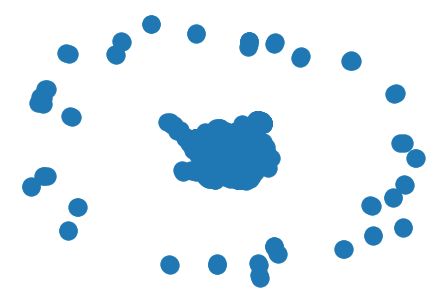

In [32]:
nx.draw(channel_graph, with_labels=False)

In [33]:
g=Network(height=3200, width=3200, notebook=True)


g.add_nodes(list(channel_graph.nodes()))
g.add_edges(list(channel_graph.edges()))


g.show("graph.html")

In [34]:
btc_key_graph = nx.Graph()

cursor.execute('select raw_data from channels')
unique_channels = [ast.literal_eval(element[0]) for element in cursor.fetchall()]

for channel in unique_channels:
    btc_key_graph.add_edge(channel['btc1_pub'], channel['btc2_pub'])

In [35]:
print(str(btc_key_graph.number_of_edges()) + ' channels in graph')
print(str(btc_key_graph.number_of_nodes()) + ' keys in graph')

print(str(btc_key_graph.number_of_edges()*2-btc_key_graph.number_of_nodes()) + ' keys are reused')

degree_centrality_keys = nx.degree_centrality(btc_key_graph)

df_degree_centrality_keys = pd.DataFrame({'keys': list(degree_centrality_keys.keys()), 'centralities': list(degree_centrality_keys.values())})

print('Top 5 reused keys')

df_degree_centrality_keys.nlargest(5, 'centralities')

40184 channels in graph
80305 keys in graph
63 keys are reused
Top 5 reused keys


,keys,centralities
2362,03133cd8182af2d26c64d3a294266e688667b7f1a8e0be...,0.000025
2924,021bc82e0bdee69e2cc8ed1a4f239cfa724c5c7d06f04a...,0.000025
3083,031375e3a1f3210173c16a9dda13227b1cd9550d6026fb...,0.000025
4656,025593991d5e8aed219600f62ef9ced15c5ed45e86fbf0...,0.000025
5245,03592202360003596af0a9512c9b1a26d7034317c8fbf5...,0.000025


In [36]:
df_degree_centrality_keys.at[2362, 'keys']

'03133cd8182af2d26c64d3a294266e688667b7f1a8e0be4beddc1166be18f85099'

In [37]:
g_keys=Network(height=3200, width=3200, notebook=True)


g_keys.add_nodes(list(btc_key_graph.nodes()))
g_keys.add_edges(list(btc_key_graph.edges()))

g_keys.show("graph_btc_key.html")

In [35]:
cursor.execute('select raw_data from nodes')
nodes = [ast.literal_eval(element[0]) for element in cursor.fetchall()]

print(str(len(nodes)) + ' nodes')

ip_addresses = {}

for node in nodes:
    ip_address = get_ip_from_node(node)
    try:
        if ip_address == None:
            ip_addresses["None"] += 1
        else:
            ip_addresses[ip_address] += 1
    except KeyError as e:
        if ip_address == None:
            ip_addresses["None"] = 1
        else:
            ip_addresses[ip_address] = 1

ip_addresses = {k: v for k, v in sorted(ip_addresses.items(), key=lambda item: item[1])}

6854 nodes


In [32]:
counted_ip_addresses = {}

for key in ip_addresses.keys():
    try:
        counted_ip_addresses[ip_addresses[key]] += 1
    except KeyError as e:
        counted_ip_addresses[ip_addresses[key]] = 1

KeyboardInterrupt: 

In [36]:
for key in ip_addresses.keys():
    if ip_addresses[key] > 3:
        print(key + ': ' + str(ip_addresses[key]))

127.0.0.1: 4
38.27.130.87: 4
188.165.223.61: 5
0.0.0.0: 8
195.95.224.2: 20
Other: 37
Tor: 1530
None: 2554


In [21]:
df_counted_ip_addresses = pd.DataFrame({'type': list(counted_ip_addresses.keys()), 'count': list(counted_ip_addresses.values())})

df_counted_ip_addresses

,type,count
0,1,2526
1,2,71
2,3,8
3,4,2
4,5,1
5,8,1
6,20,1
7,37,1
8,1530,1
9,2554,1


In [ ]:
fig = px.pie(df_counted_ip_addresses, values='count', names='type', title="Channels per count of IP address")
fig.show()

In [5]:
cursor.execute('select * from potential_txes p inner join channels c on p.tx = c.funding_tx')
closed_channels_onchain = [create_json_for_joined_table_entry(element) for element in cursor.fetchall()]

print(len(closed_channels_onchain))

KeyboardInterrupt: 

In [41]:
body = {'username': 'graphsense_demo', 'password': 'preview'}

response = requests.post(url = 'http://192.168.243.2:9000/login', json=body)
jwt = response.json()['Authorization']

header = {'Content-Type': 'application/json', 'Authorization': jwt}

for channel in closed_channels_onchain:
    response = requests.get(url = 'http://192.168.243.2:9000/btc/addresses/[ADDR]'.replace('[ADDR]', channel['on_chain']['btc_addr_1']), headers=header)
    
    if not response.status_code == 404 and not response.status_code == 500:
        print(response.json())
        
    response = requests.get(url = 'http://192.168.243.2:9000/btc/addresses/[ADDR]'.replace('[ADDR]', channel['on_chain']['btc_addr_2']), headers=header)
        
    if not response.status_code == 404 and not response.status_code == 500:
        print(response.json())
  